1. Tìm hình dạng trong hình ảnh bằng Python và OpenCV.

2. Hãy xem xét một hình ảnh , thêm nhiễu Gaussian vào hình ảnh. Triển khai và kiểm tra thuật toán của Otsu với hình ảnh này.

3. Thực hiện phân đoạn hình ảnh tương tác với thuật toán graph cut

1. Tìm hình dạng trong hình ảnh bằng Python và OpenCV.

In [8]:
from shapedetector import ShapeDetector
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [19]:
image = cv2.imread("image.png")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])
# convert the resized image to grayscale, blur it slightly,
# and threshold it
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
# tìm các contour trong hình ảnh được threshold và chạy phát hiện hình dạng
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

In [20]:
# lặp qua các contour
for c in cnts:
    # tính toán tâm của đường contour, sau đó phát hiện tên 
    # của hình dạng
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)
    # nhân tọa độ của đường contour (x, y) với tỷ lệ thay đổi kích thước, 
    # sau đó vẽ các đường contour và tên của hình dạng trên hình ảnh
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, (255, 255, 255), 2)

    cv2.imshow("Image", image)
    cv2.waitKey(0)

<img src="result.png" style="width:700px;height:400;">

2. Hãy xem xét một hình ảnh , thêm nhiễu Gaussian vào hình ảnh. Triển khai và kiểm tra thuật toán của Otsu với hình ảnh này.

(-0.5, 1023.5, 684.5, -0.5)

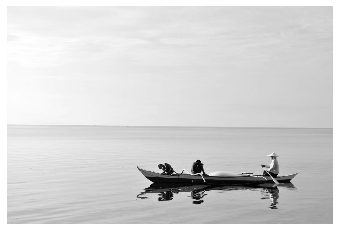

In [43]:
image = cv2.imread("bai3.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap="gray")
plt.axis("off")

(-12.75, 267.75, -903.0500000000001, 18964.05)

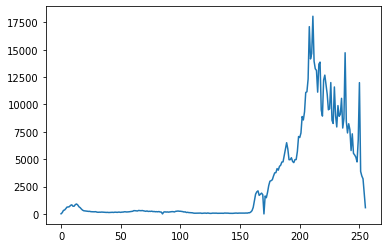

In [44]:
hist, bin_edges = np.histogram(image, bins=256)
plt.plot(range(256),hist)
plt.axis("on")

In [45]:
# Áp dụng phương pháp Otsu, đặt giá trị flag thành cv.THRESH_OTSU.
# Giá trị ngưỡng tối ưu được xác định tự động.
otsu_threshold, image_result = cv2.threshold(
    image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)
print("Ngưỡng đạt được: ", otsu_threshold)

Ngưỡng đạt được:  132.0


(-0.5, 1023.5, 684.5, -0.5)

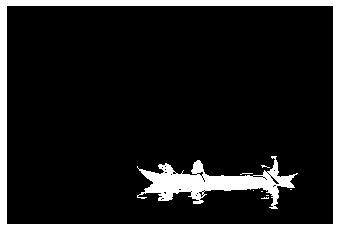

In [46]:
plt.imshow(image_result,cmap="gray")
plt.axis("off")

3. Thực hiện phân đoạn hình ảnh tương tác với [graph cut](https://www.pyimagesearch.com/2020/07/27/opencv-grabcut-foreground-segmentation-and-extraction/)


In [25]:
import numpy as np
import time
import cv2
import os

In [35]:
image = cv2.imread("IMG_2712.PNG")
mask = np.zeros(image.shape[:2], dtype="uint8")
rect = (258,131, 489, 971)
# cấp phát bộ nhớ cho hai mảng mà thuật toán GrabCut 
# sử dụng nội bộ khi phân đoạn foreground from the background
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
# áp dụng GrabCut bằng phương pháp phân đoạn bounding box
start = time.time()
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,
	fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_RECT)
end = time.time()
print("[INFO] applying GrabCut took {:.2f} seconds".format(end - start))

[INFO] applying GrabCut took 7.00 seconds


In [41]:
# mặt nạ đầu ra có các giá trị đầu ra có thể có, đánh dấu mỗi pixel 
# trong mặt nạ là (1) definite background, (2) definite foreground, 
# (3) probable background, and (4) probable foreground
values = (
    ("Definite Background", cv2.GC_BGD),
    ("Probable Background", cv2.GC_PR_BGD),
    ("Definite Foreground", cv2.GC_FGD),
    ("Probable Foreground", cv2.GC_PR_FGD),
)
# lặp qua các giá trị mặt nạ GrabCut
for (name, value) in values:
    # tạo một mặt nạ cho giá trị hiện tại
    valueMask = (mask == value).astype("uint8") * 255
    # hiển thị mặt nạ
    cv2.imshow(name, valueMask)
    cv2.waitKey(0)

In [37]:
# chúng ta sẽ đặt tất cả pixel nền xác định và pixel nền có 
# thể thành 0 trong khi pixel foreground và pixel foreground có thể xác định được đặt thành 1
outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),
	0, 1)
# scale the mask from the range [0, 1] to [0, 255]
outputMask = (outputMask * 255).astype("uint8")
# áp dụng bitwise AND cho hình ảnh bằng cách sử dụng mặt nạ 
# do GrabCut tạo ra để tạo hình ảnh đầu ra cuối cùng của chúng tôi
output = cv2.bitwise_and(image, image, mask=outputMask)

(-0.5, 851.5, 1144.5, -0.5)

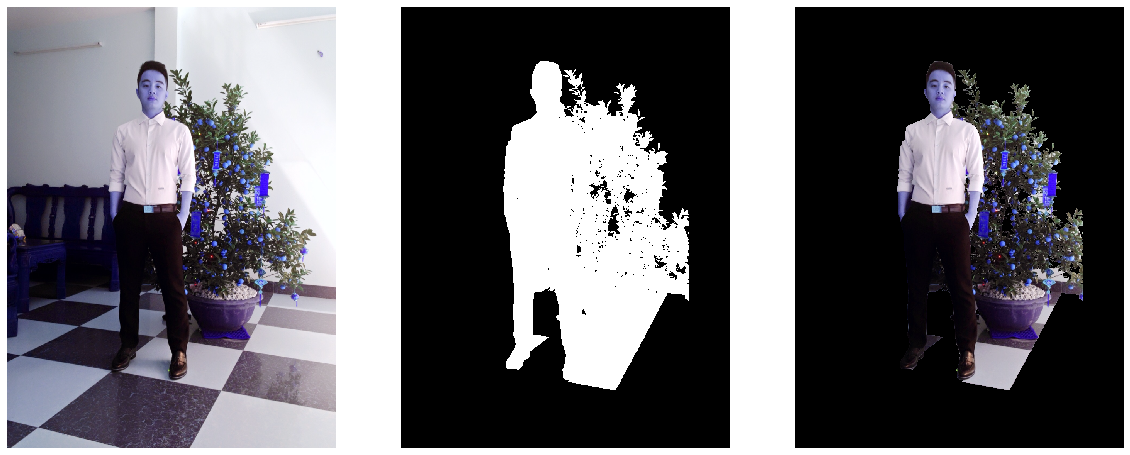

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image,cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(outputMask,cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(output,cmap="gray")
plt.axis("off")